<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

# Condition Monitoring of Drive Trains by Data Fusion of Acoustic Emission and Vibration Sensors

### Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Dirk Mayer, Christian Schmidt, Samuel Klein and Hans-Georg Herrmann

---

## Notebook *ClassifierTraining_06_VB_MEAN_STD_FFT_SimpleDenseModel*

This notebook demonstrates the training of a classification model based on a simple dense model. For the classification the Vibration signals are used.  

---

<span style="color:gray">
Version: 1.1.3 (June 14, 2021) <br>
Authors: André Schneider, Oliver Mey 
 </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import pandas as pd
import urllib, json
import seaborn as sns
import colorcet as cc
import tensorflow as tf
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from glob import glob
from itertools import chain
from matplotlib.cbook import flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Softmax, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set(rc={'figure.figsize':(16, 4)})

In [2]:
project = 'SkaliSens_07'
experiment = 'ClassifierTraining_06'
approach = 'VB_MEAN_STD_FFT_SimpleDenseModel'
revision = '$Id$'

## Configuration

The *path* must specify the directory into which the Fordatis data set was downloaded and unpacked.

This notebook demonstrates the classification based on the measured Acoustic Emission signals. 29 measurement series are available. 22 series (see masks, ['1\*1', '3\*']) are used for the training and test of the classification model. 7 series (['1\*2']) are used for the evaluation of the trained model.

In [3]:
path = 'fordatis'
masks = ['1*1', '3*2']
masks_evaluate = ['1*2']
speeds = [600, 1000]
labels = ['None', 'Inner', 'Outer', 'Balls']
sensors = ['vb', 'w']
frequencies = [8192.0, 0.0]
crop = [[10.0, 2000.0], [0.0, 0.0]]

In [4]:
f_vb = np.linspace(0.0, frequencies[0]/2,int(frequencies[0]/2)+1)
i1 = np.argwhere(f_vb >= crop[0][0])[0][0]
i2 = np.argwhere(f_vb <= crop[0][1])[-1][0]
inputs_vb = i2 - i1
inputs_w = 1
crop_vb = [slice(None, None),slice(i1, i2)]
crop_w = [slice(None, None),slice(None, None)]
crops = {'vb':crop_vb, 'w':crop_w}

## Function Definitions for Feature Extraction

#### Utility Function

In [5]:
def fir_(y, u, nb):
    N = y.size - nb -1
    phi = np.zeros(nb)
    PHI = np.zeros((N, nb))
    for i in range(N):
        phi[0:nb] = u[nb+i:i:-1]
        PHI[i, :] = phi
    W = np.dot(np.linalg.pinv(PHI.T @ PHI), PHI.T @ y[nb+1:])
    return W

def wiener_(df, f_remove, fps, duration, A=1, order=2):
    t = np.linspace(0,duration, int(fps*duration))
    X = df.values
    for fc in f_remove:
        for i in range(X.shape[0]):
            u = A * np.sin(2 * np.pi * fc * t / duration)
            W = fir_(X[i,:], u, order)
            ym = np.zeros(order)
            yout  = np.zeros_like(X[i,:])
            for k, _ in enumerate(u):
                yout[k] = np.dot(W, ym)
                ym = np.hstack((np.array(u[k]), ym[0:-1]))
            X[i,:]=X[i,:] - yout
    df_out = df.copy()
    df_out.iloc[:,:] = X
    return df_out

#### Functions for Feature Extraction Pipeline

In [6]:
def shrink(X, P=None):
    speeds = P[0]['speeds']
    X[1].columns = ['w']
    T = [X[1][X[1]['w'] == speed].index.to_numpy() for speed in speeds]
    X[0] = pd.concat([X[0][X[0].index.to_series().between(t[0], t[1])] for t in T])
    return X

def bessel(X, P=None):
    b, a = sc.signal.bessel(N=4, Wn=5, btype='highpass', analog=False, norm='phase', fs=frequencies[0])
    x = X[0].copy()
    x = sc.signal.filtfilt(b,a,x.values.flatten()).reshape(-1, int(frequencies[0]))
    X[0] = pd.DataFrame(x, index=X[0].index)
    return X

def wiener(X, P=None):
    x = X[0].copy()
    f_remove = [50, 100, 200, 300, 400, 500]
    duration = 1.0
    x = wiener_(x, f_remove, frequencies[0], duration)
    x.index = X[0].index
    X[0] = x    
    return X

def mean_std_fft_crop(X, P=None):
    X_ = [X[0]]
    P_ = [P[0]]
    mean = [x.mean(axis=1) for x in X_]
    std = [x.std(axis=1) for x in X_]
    X_ = [pd.DataFrame(np.abs(np.fft.rfft(x)), index=x.index) for x in X_]
    for x in X_: x[0]=0
    crops = [(p['rows'], p['columns']) for p in P_]
    X_ = [x.iloc[crop] for x,crop in zip(X_,crops)]
    for i in [0]:
        X_[i]['mean'+str(i)] = mean[i].values
        X_[i]['std'+str(i)] = std[i].values
    X[0] = X_[0]
    return X

## Function Definitions for Data Preparation and Model Training

In [7]:
def setup(path, masks):
    files = [sorted(glob(path + '/data/' + mask)) for mask in masks]
    files = list(chain(*files))
    measurements = [os.path.basename(str(file)) for file in files]
    descriptors = [pd.read_json(path + '/measurements/' + measurement + '.json') 
                   for measurement in measurements]
    usecases = [labels.index(descriptor.loc['usecasegroup', 'measurement']) 
                for descriptor in descriptors]
    return measurements, usecases

def load_samples(path, measurement, sensor):
    samples = pd.read_csv(path + '/data/' + measurement + '/' + sensor + '.csv', 
                   parse_dates=[0], index_col=0, sep=' ', header=None)
    samples.index = samples.index.values.astype('datetime64[us]')
    return samples

def extract_features(X, F, P):
    for f in F: X = [f(x,p) for x,p in zip(X,P)]
    return X

def split(X, U, ratios=[0.8, 0.2]):
    N = [x[0].shape[0] for x in X]
    y = [pd.DataFrame(np.ones(n)*u, index=x[0].index, dtype=np.int8) for n,u,x in zip(N,U,X)]
    y = pd.concat(y).sort_index()
    X = [pd.concat([x[i] for x in X]).sort_index() for i in range(len(X[0]))]
    I = np.random.permutation(len(X[0]))
    ratios = np.cumsum(list(flatten([0.0, ratios])))
    IX = [int(ratio*len(I)) for ratio in ratios]
    II = [I[IX[i]:IX[i+1]] for i in range(len(IX)-1)]
    return X, y, II

def encode(y):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(y.to_numpy().reshape(-1, 1))
    y = pd.DataFrame(encoder.transform(y.to_numpy().reshape(-1, 1)), index=y.index)
    return y
    
def scale(X, y, I, scalers=None):
    X0 = X[0].iloc[I,:]
    T = X0.index.floor('s')
    X1 = X[1][X[1].index.isin(T)]
    if scalers==None:
        scalers = [RobustScaler(quantile_range=(5,95)).fit(x) for x in [X0, X1]]
    X = [pd.DataFrame(scaler.transform(x), index=x.index) for scaler,x in zip(scalers, X)]
    return X, y, scalers

def generate(X, y, I, batch_size=-1, join=True):    
    k = 0
    while True:
        if batch_size > 0:
            batch_range = [i%len(I) for i in range(k*batch_size,(k+1)*batch_size)]
        else:
            batch_range = slice(None, None)
        X0 = X[0].iloc[I[batch_range]]
        yy = y.iloc[I[batch_range]]
        T = X0.index.floor('s')
        X1 = X[1].iloc[[X[1].index.get_loc(t, method='ffill') for t in T], 0].to_frame()
        yy = yy.to_numpy(dtype=np.int)
        if join:
            XX = np.concatenate([x.to_numpy() for x in [X0, X1]], axis=1)
        else:
            XX = [x.to_numpy() for x in [X0, X1]]
            yy = [yy, yy]
        k = k+1                 
        yield XX, yy
    return

def prepare(path, masks='*', sensors=[], functions=[], ratios=[0.8, 0.2], scalers=None):
    measurements, usecases = setup(path, masks)
    parameters = [[dict([('rows', crops[sensor][0]), ('columns', crops[sensor][1]),
               ('speeds', speeds)]) for sensor in sensors] for measurement in measurements]
    samples = [[load_samples(path, measurement, sensor) for sensor in sensors] 
               for measurement in measurements]
    X = extract_features(samples, functions, parameters)
    X, y, I = split(X, usecases, ratios)
    X, y, scalers = scale(X, y, I[0], scalers)
    y = encode(y)
    return X, y, I, scalers

def create_model(X):
    n_layers_vb = 2
    n_inputs_vb = inputs_vb + 2
    n_inputs_w = inputs_w

    X_in_vb = Input(shape=(n_inputs_vb,), name="vb_input")
    x = X_in_vb
    for j in range(n_layers_vb):
        x = Dense(units = 1024, activation="linear", name='vb_dense_'+str(j))(x)
        x = LeakyReLU(alpha=0.05, name='vb_relu_'+str(j))(x)
        x = Dropout(rate=0.2, name='vb_dropout_'+str(j))(x)
    X_out_vb_pre = Dense(units = 4, activation = 'linear', name="vb_output_before_activation")(x)
    X_out_vb = Softmax(name="vb_output")(X_out_vb_pre)    
    model = Model(X_in_vb, X_out_vb)
    
    model.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])
    model.summary()
    return model

def train_model(X, y, I, model):
    X_train, y_train = next(generate(X, y, I[0]))
    X_test, y_test = next(generate(X, y, I[1]))
    X_train_vb = X_train[:,:inputs_vb+2]
    X_test_vb = X_test[:,:inputs_vb+2]
    
    checkpoint = ModelCheckpoint('./model_vb_06.h5', monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    model.fit(X_train_vb, y_train, epochs = 10, batch_size = 32, 
                 validation_data=(X_test_vb, y_test))
    return model

def plot_results(y, y_predict):
    confusion = tf.math.confusion_matrix(labels=tf.argmax(y,1),
                                         predictions=tf.argmax(y_predict,1))
    confusion = tf.make_ndarray(tf.make_tensor_proto(confusion))
    cm = pd.DataFrame(confusion, index = ["None", "Inner", "Outer", "Ball"],
                      columns = ["None", "Inner", "Outer", "Ball"])
    fig=plt.figure(figsize = (10,8))
    sns.heatmap(cm/np.sum(cm, axis=1).values.reshape(-1,1), annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    return

## Data Aggregation and Feature Extraction

#### Feature Extraction Pipeline

In [8]:
functions = [shrink, mean_std_fft_crop]

#### Data for Training & Test

In [9]:
X, y, I, scalers = prepare(path, masks, sensors, functions, ratios=[0.8, 0.2])

#### Data for Evaluation

In [10]:
X_, y_, I_, _ = prepare(path, masks_evaluate, sensors, functions, ratios=[1.0], scalers=scalers)

In [11]:
X_evaluate, y_evaluate = next(generate(X_, y_, I_[0], join=False))

## Creating and Compiling the Model Structure

In [12]:
model = create_model(X)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vb_input (InputLayer)        [(None, 1992)]            0         
_________________________________________________________________
vb_dense_0 (Dense)           (None, 1024)              2040832   
_________________________________________________________________
vb_relu_0 (LeakyReLU)        (None, 1024)              0         
_________________________________________________________________
vb_dropout_0 (Dropout)       (None, 1024)              0         
_________________________________________________________________
vb_dense_1 (Dense)           (None, 1024)              1049600   
_________________________________________________________________
vb_relu_1 (LeakyReLU)        (None, 1024)              0         
_________________________________________________________________
vb_dropout_1 (Dropout)       (None, 1024)              0     

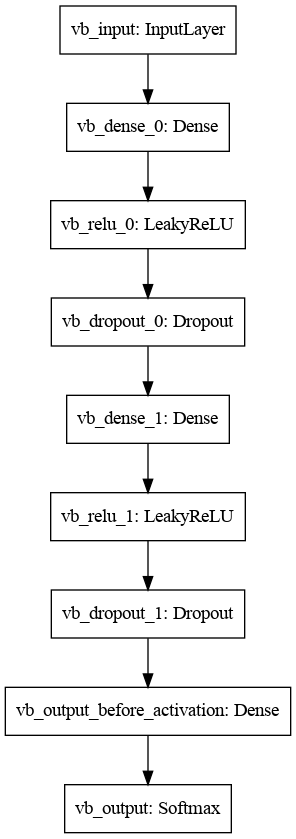

In [13]:
plot_model(model)

## Training of the Model Using the Training&Test Data

In [ ]:
model = train_model(X, y, I, model)

## Evaluation of the Trained Model Using the Evaluation Data

In [15]:
y_predict = model.predict(X_evaluate[0])

## Classification Results

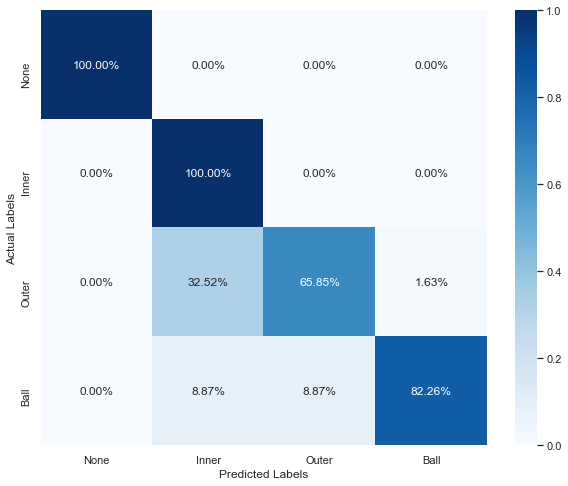

In [16]:
plot_results(y_evaluate[0], y_predict)